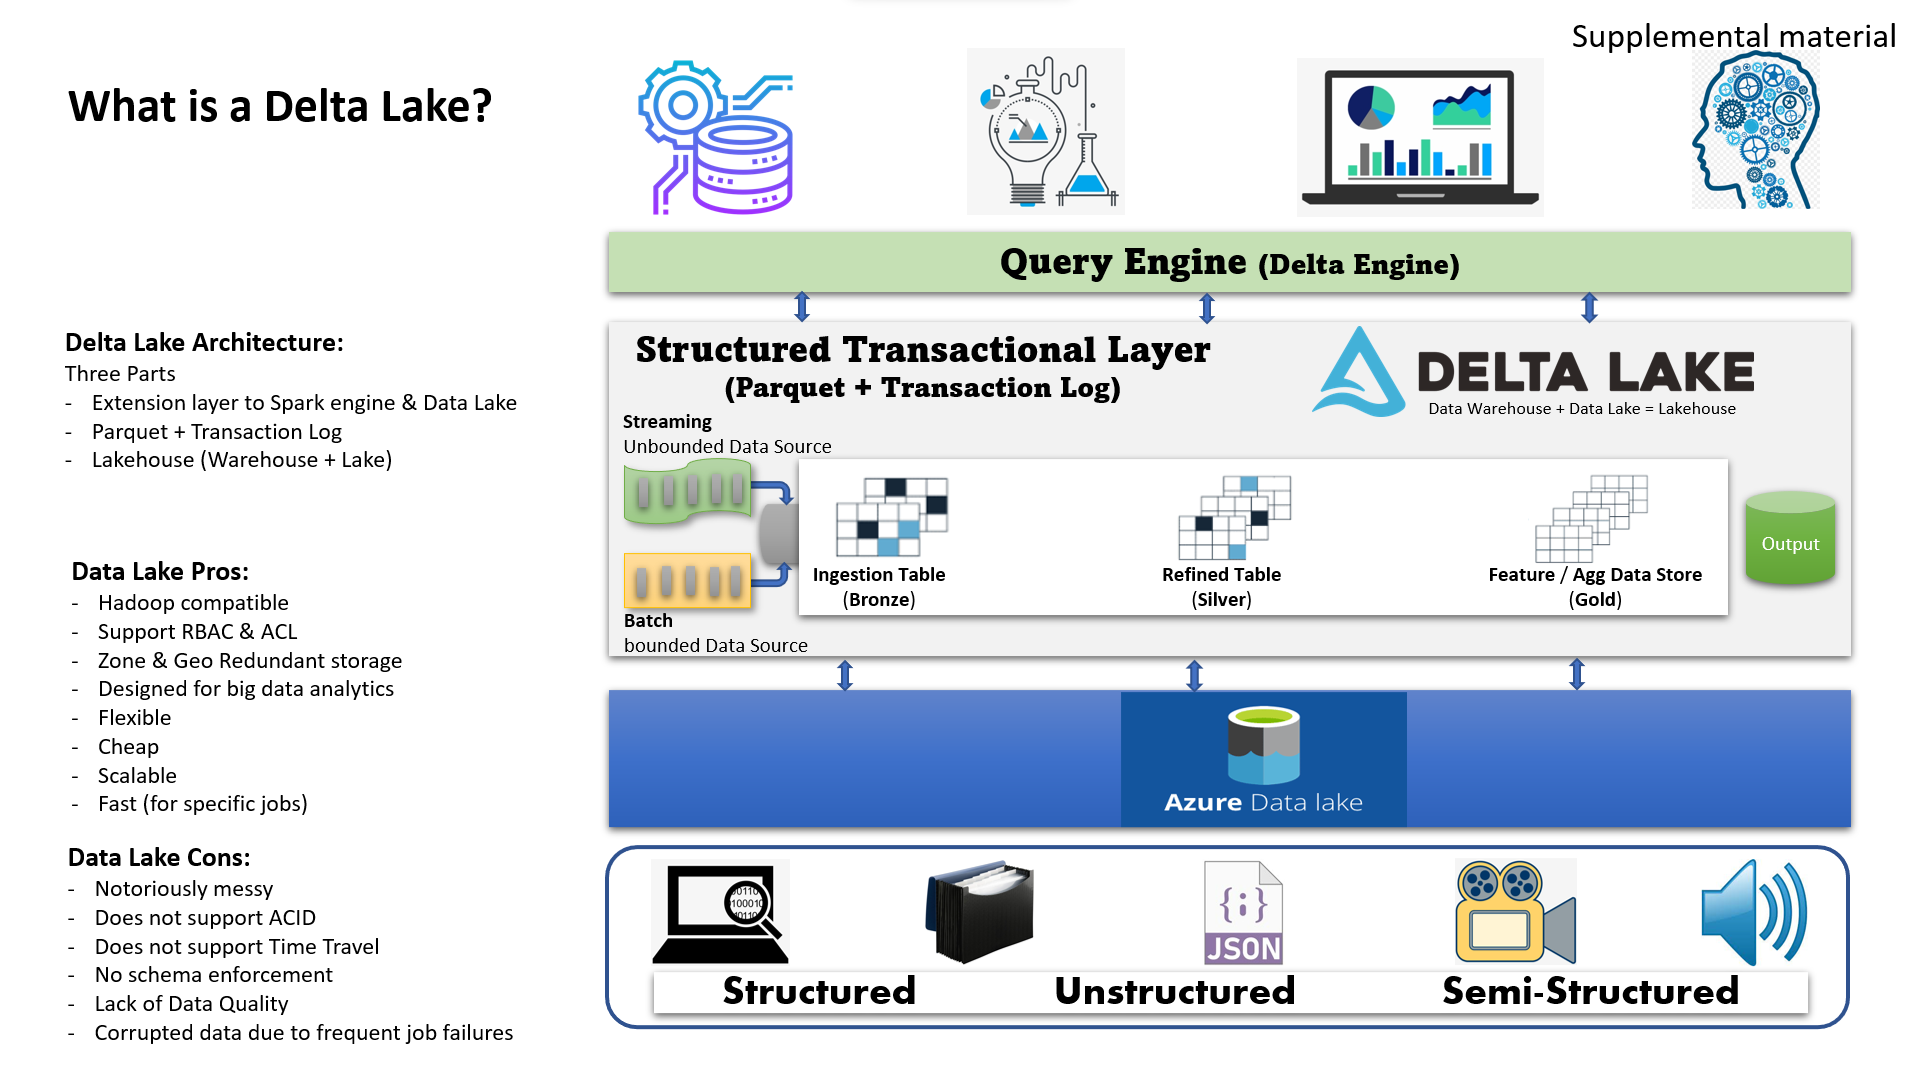

# Create and Query Azure Delta Lake Tables

In [ ]:
%%pyspark
csvFilePath = 'Files/csv/demofiles/PurchaseOrderDetail.csv'
DeltaDF = spark.read.load(
     csvFilePath
   , format='csv'
   , header=True
   , inferschema=True
)

# Display output
display(DeltaDF.limit(3))

# Display the schema definition
DeltaDF.printSchema()

##### Let us perform some basic transformation

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import DecimalType,datetime

group_cols = ["PurchaseOrderID", "DueDate","ModifiedDate"]

DeltaDF_Agg = (
   DeltaDF.groupBy(group_cols)
          .agg(
              sum("LineTotal").alias("SubTotal")
          )
).withColumn(
    "SubTotal",col("SubTotal").cast(DecimalType(18,2))
).select(
          "PurchaseOrderID"
        , date_format("DueDate","MM-dd-yyyy").alias("DueDate")
        , date_format("ModifiedDate","MM-dd-yyyy").alias("ModifiedDate")
        , "SubTotal"
)

display(DeltaDF.limit(5))

##### Saving Dataframe output as a Delta Table file

In [ ]:
%%pyspark

deltaFilePath = "abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales"

# Save as a Delta files
(
DeltaDF_Agg.write.format("delta")
           .mode("overwrite")
           .option('overwriteSchema','true')
           .save(deltaFilePath)
)

##### Let us read the Delta Table

In [ ]:
df = spark.read.format("delta").load(deltaFilePath)

# Apply a where clause
df_filtered = df.where("PurchaseOrderID = '4012'")
display(df_filtered)

##### Let us check the Delta Log file

In [ ]:
%%sql
DESCRIBE HISTORY 'abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/'

##### Let us issue an update statement.

In [ ]:
from delta.tables import *
from pyspark.sql.functions import *

deltaTable = DeltaTable.forPath(spark, deltaFilePath)

# Declare the predicate by using a SQL-formatted string.
deltaTable.update(
  condition = "PurchaseOrderID = 4012",
  set = { 
          "ModifiedDate": "'8-12-2017'",
          "DueDate": "'8-12-2017'"
        }
)

##### Let's verify the version history

In [ ]:
%%sql
DESCRIBE HISTORY 'abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/'

##### Let's select the old version
- This is what we called Time Traveling

In [ ]:
# Why the correct value is not showing?
df2 = spark.read.format("delta").option("versionAsOf", 1).load(deltaFilePath)
display(df2.where("PurchaseOrderID = 4012"))

##### Let's query the latest version

In [ ]:
# Why the correct value is not showing?
df2 = spark.read.format("delta").option("versionAsOf", 1).load(deltaFilePath)
display(df2.where("PurchaseOrderID = 4012"))

##### Let's issue a delete statement

In [ ]:
from delta.tables import *
from pyspark.sql.functions import *

deltaTable = DeltaTable.forPath(spark, deltaFilePath)

# Declare the predicate by using a SQL-formatted string.
deltaTable.delete("PurchaseOrderID = 4012")

##### Let's verify the version history

In [ ]:
%%sql
DESCRIBE HISTORY 'abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/'

##### Let's verify that the record has been deleted

In [ ]:
# Why the correct value is not showing?
df2 = spark.read.format("delta").option("versionAsOf", 1).load(deltaFilePath)
display(df2.where("PurchaseOrderID = 4012"))

#### Now, let us bring SQL into the picture
- Creating a SQL table using this Delta table file directory

In [ ]:
%%sql

CREATE TABLE BicycleSales
USING DELTA
LOCATION 'Files/deltafiles/BicycleSales/';

##### By default, SQL will query the latest version

In [ ]:
%%sql
-- About to update these records
SELECT * 
FROM BicycleSales
WHERE PurchaseOrderID = 4012

##### You can explicitly tell SQL which record version to query from the Delta table.

In [ ]:
%%sql
SELECT *
FROM (
  SELECT *, VERSION() as version
  FROM BicycleSales
  VERSION AS OF 0  -- replace with your version number
) 
WHERE PurchaseOrderID = 4012;

##### Let us revisit our version history

In [ ]:
%%sql
DESCRIBE HISTORY 'abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/'

##### Let us issue an insert statement

In [ ]:
%%sql
INSERT INTO BicycleSales
SELECT 4013,'7/24/2015','8/12/2015',41.57

In [ ]:
%%sql
DESCRIBE HISTORY 'abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/'

# Delta File Table Maintenance
- **Vacuum:** This operation removes old files that are no longer referenced by a Delta table log. Files need to be older than the retention threshold for them to be removed.

- **Retention Threshold:** The default file retention threshold is seven days. This means that files older than seven days, which are not referenced by the Delta table log, will be removed when the vacuum operation is performed.

- **Note:** Setting a shorter retention period impacts Delta’s time travel capabilities. It’s a general best practice to set a retention interval to at least seven days, because old snapshots and uncommitted files can still be in use by the concurrent table readers and writers. Cleaning up active files with the VACUUM command might lead to reader failures or even table corruption if the uncommitted files are removed

In [ ]:
from delta.tables import *

pathToTable = "abfss://FabricDataAnalytics@onelake.dfs.fabric.microsoft.com/LH01.Lakehouse/Files/deltafiles/BicycleSales/"

deltaTable = DeltaTable.forPath(spark, pathToTable)

deltaTable.vacuum() # vacuum files not required by versions older than the default retention period

In [ ]:
# List all tables in the Spark catalog
tables = spark.catalog.listTables()
for table in tables:
    print(table.name)


In [ ]:
deltaTable.vacuum(100)     # vacuum files not required by versions more than 100 hours old

In [ ]:
# Vacuum DRY RUN
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", False)

### Claning up

In [ ]:
%%sql

DROP TABLE BicycleSales

In [ ]:
# Delete Delta Table (folder)
delta_table_path = "Files/deltafiles/BicycleSales"
mssparkutils.fs.rm(delta_table_path, recurse=True)